# Multi-Layer Perceptron with CIFAR10 classification 

## 1. Module Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import datasets
import torchvision.transforms as transforms
                                                                                                                                                
import torch.optim as optim

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

## 2. 딥러닝 모델을 설계할 때 활용하는 장비 확인

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 1.11.0  Device: cpu


## 3. CIFAR10 데이터 다운로드 (Train data와 Test data 분리하기)

In [3]:
BATCH_SIZE = 32 

train_data = datasets.CIFAR10('data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.CIFAR10('data', train=False, download=True, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)


2.1%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

4.6%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

7.2%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

11.9%IOPub me

Extracting data\cifar-10-python.tar.gz to data
Files already downloaded and verified


## 4. 첫번째 batch 데이터의 크기와 타입을 확인하기

In [4]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


## 4. torch.nn을 이용하여 모델 만들기

   1) input layer (입력층), hidden layer (은닉층), output layer (출력층) 으로 이루어진 모델을 이용

   2) 하나의 hidden layer (은닉층)만 이용 - 은닉층의 개수는 100개로 하세요
   
   3) nn.Module을 상속 받아 만들 것!
   
   4) nn.Linear와 nn.ReLU를 사용할 것!


In [5]:
import torch.nn as nn

class Model(nn.Module):
    
    def __init__(self):        
        super(Model,self).__init__()
        self.fc1 = nn.Linear(3072,100)
        self.fc2 = nn.Linear(100,10)
        self.relu = nn.ReLU()
            
    def forward(self,x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

## 5. 초기화를 위한 함수 만들기

In [6]:
def init_constants(m):
    if isinstance(m, nn.Linear):
        nn.init.constant_(m.weight.data,0)
        nn.init.constant_(m.bias.data, 0)
        
def init_normal(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.normal_(m.weight)      

def init_xaiver(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        
def init_kaiming(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.kaiming_uniform_(m.weight)

## 6. 모델 객체 만들고 다르게 초기화 하기

In [7]:
########## 아래 채우시오에 함수명을 적으면됩니다.

network_const = Model()
network_const.apply(init_constants)

network_normal = Model()
network_normal.apply(init_normal)

network_xaiver = Model()
network_xaiver.apply(init_xaiver)

network_kaiming = Model()
network_kaiming.apply(init_kaiming)


Model(
  (fc1): Linear(in_features=3072, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (relu): ReLU()
)

## 7. 학습 준비하기

1) 1 epoch를 학습할 수 있는 함수 만들기

2) 1 테스트 데이터의 정확도 계산할 수 있는 함수 만들기

In [8]:
def training_epoch(train_loader, network, loss_func, optimizer, epoch):
    train_losses = []
    train_correct = 0
    log_interval = 500
    
    for batch_idx, (image, label) in enumerate(train_loader):
        # 미분값의 초기화
        optimizer.zero_grad()
            
        # 이미지를 (batch_size, 3072) 차원의 메트릭스로 만드세요
        batch_size = image.size()[0]
        image = image.view(-1,3*32*32)

        # Forward propagration 계산하기.
        outputs = network.forward(image)
        
        
        # Cross_entropy 함수를 적용하여 loss를 구하고 저장하기
        cls_loss = nn.CrossEntropyLoss()
        loss = cls_loss(outputs,label)
        train_losses.append(loss.item())

        # training accuracy 정확도 구하기 위해 맞는 샘플 개수 세기
        pred = torch.argmax(outputs.data, 1)
        train_correct += pred.eq(label).sum()

        # Gradient 구하기
        loss.backward()

        # weight값 update 하기
        optimizer.step()

        # 학습 상황 출력
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'
                  .format(epoch, batch_idx * len(label), len(train_loader.dataset),100. * batch_idx / len(train_loader),
                          loss.item()))
            
    return train_losses, train_correct

In [9]:
def test_epoch(test_loader, network, loss_func):
    correct = 0
    
    test_losses = []
    
    with torch.no_grad():
        for batch_idx, (image, label) in enumerate(test_loader):
            batch_size = image.size()[0]
            image = image.view(-1, 3*32*32)

            # Forward propagration 계산하기.
            outputs = network.forward(image)

            # Cross_entropy 함수를 적용하여 loss를 구하기
            cls_loss = nn.CrossEntropyLoss()
            loss = cls_loss(outputs,label)
            test_losses.append(loss.item())

            # Batch 별로 정확도 구하기
            pred = torch.argmax(outputs.data, 1)
            correct += pred.eq(label).sum()

        # 전체 정확도 구하기
        test_accuracy = 100. * correct / len(test_loader.dataset)

        #중간결과 출력
        print('Test set: Accuracy: {}/{} ({:.0f}%)\n'
              .format(correct, len(test_loader.dataset),100. * correct / len(test_loader.dataset)))
    return test_losses, test_accuracy


## 7. 위 정의된 함수로 학습 함수 만들기

In [10]:
def training(network):
    
    learning_rate = 0.01
    epoches = 20
    
    cls_loss = nn.CrossEntropyLoss()
    optimizer = optim.SGD(network.parameters(), lr=learning_rate)
    
    train_losses_per_epoch = []
    test_losses_per_epoch = []
    
    train_accuracies = []
    test_accuracies = []
    
    
    for epoch in range(epoches):
                
        # 모델를 학습 중이라고 선언하기
        network.train()
        
        train_losses, train_correct = training_epoch(train_loader,network,cls_loss,optimizer, epoch)
        
        # epoch 별로 loss 평균값, 정확도 구하기
        average_loss = np.mean(train_losses)
        train_losses_per_epoch.append(average_loss)
        
        train_accuracy = train_correct / len(train_loader.dataset) * 100
        train_accuracies.append(train_accuracy)
        
        # epoch 별로 정확도 출력
        print('\nTraining set: Accuracy: {}/{} ({:.0f}%)'
              .format(train_correct, len(train_loader.dataset),100. * train_correct / len(train_loader.dataset)))

        
        ### 학습 중에 test 결과 보기
        
        # 모델 test 중인 것을 선언하기
        network.eval()
        
        correct = 0
        with torch.no_grad():
            test_losses, test_accuracy = test_epoch(test_loader, network,cls_loss)

        test_losses_per_epoch.append(np.mean(test_losses))
        test_accuracies.append(test_accuracy)
        
    return train_losses_per_epoch, test_losses_per_epoch, train_accuracies, test_accuracies


In [11]:
rlt_const = training( network_const)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.302585
Train Epoch: 0 [16000/50000 (32%)]	Loss: 2.301526
Train Epoch: 0 [32000/50000 (64%)]	Loss: 2.303564
Train Epoch: 0 [48000/50000 (96%)]	Loss: 2.301433

Training set: Accuracy: 4844/50000 (10%)
Test set: Accuracy: 1000/10000 (10%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.303619
Train Epoch: 1 [16000/50000 (32%)]	Loss: 2.301910
Train Epoch: 1 [32000/50000 (64%)]	Loss: 2.303572
Train Epoch: 1 [48000/50000 (96%)]	Loss: 2.301404

Training set: Accuracy: 4730/50000 (9%)
Test set: Accuracy: 1000/10000 (10%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 2.303838
Train Epoch: 2 [16000/50000 (32%)]	Loss: 2.301992
Train Epoch: 2 [32000/50000 (64%)]	Loss: 2.303575
Train Epoch: 2 [48000/50000 (96%)]	Loss: 2.301399

Training set: Accuracy: 4738/50000 (9%)
Test set: Accuracy: 1000/10000 (10%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 2.303884
Train Epoch: 3 [16000/50000 (32%)]	Loss: 2.302010
Train Epoch: 3 [32000/50000 (64%)]	Loss: 2.303575
Train Epoch: 3 [48000/50000 (96%

In [12]:
rlt_normal = training(network_normal)

Train Epoch: 0 [0/50000 (0%)]	Loss: 386.687286
Train Epoch: 0 [16000/50000 (32%)]	Loss: 4.508047
Train Epoch: 0 [32000/50000 (64%)]	Loss: 2.133105
Train Epoch: 0 [48000/50000 (96%)]	Loss: 2.206378

Training set: Accuracy: 8382/50000 (17%)
Test set: Accuracy: 1553/10000 (16%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 3.405278
Train Epoch: 1 [16000/50000 (32%)]	Loss: 2.388086
Train Epoch: 1 [32000/50000 (64%)]	Loss: 2.102398
Train Epoch: 1 [48000/50000 (96%)]	Loss: 2.143768

Training set: Accuracy: 8916/50000 (18%)
Test set: Accuracy: 1879/10000 (19%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 2.719586
Train Epoch: 2 [16000/50000 (32%)]	Loss: 2.325328
Train Epoch: 2 [32000/50000 (64%)]	Loss: 2.054214
Train Epoch: 2 [48000/50000 (96%)]	Loss: 2.158396

Training set: Accuracy: 9332/50000 (19%)
Test set: Accuracy: 1841/10000 (18%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 2.509605
Train Epoch: 3 [16000/50000 (32%)]	Loss: 2.234325
Train Epoch: 3 [32000/50000 (64%)]	Loss: 2.022566
Train Epoch: 3 [48000/50000 

In [13]:
rlt_xaiver = training(network_xaiver)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.556267
Train Epoch: 0 [16000/50000 (32%)]	Loss: 1.841760
Train Epoch: 0 [32000/50000 (64%)]	Loss: 1.810570
Train Epoch: 0 [48000/50000 (96%)]	Loss: 2.186528

Training set: Accuracy: 15894/50000 (32%)
Test set: Accuracy: 3664/10000 (37%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 1.833729
Train Epoch: 1 [16000/50000 (32%)]	Loss: 1.659732
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.721016
Train Epoch: 1 [48000/50000 (96%)]	Loss: 2.185035

Training set: Accuracy: 19693/50000 (39%)
Test set: Accuracy: 3783/10000 (38%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.817020
Train Epoch: 2 [16000/50000 (32%)]	Loss: 1.582053
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.708907
Train Epoch: 2 [48000/50000 (96%)]	Loss: 2.160982

Training set: Accuracy: 21055/50000 (42%)
Test set: Accuracy: 3927/10000 (39%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.800810
Train Epoch: 3 [16000/50000 (32%)]	Loss: 1.503897
Train Epoch: 3 [32000/50000 (64%)]	Loss: 1.678832
Train Epoch: 3 [48000/50000

In [14]:
rlt_kaiming = training(network_kaiming)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.609010
Train Epoch: 0 [16000/50000 (32%)]	Loss: 1.914922
Train Epoch: 0 [32000/50000 (64%)]	Loss: 1.813802
Train Epoch: 0 [48000/50000 (96%)]	Loss: 2.261577

Training set: Accuracy: 16030/50000 (32%)
Test set: Accuracy: 3522/10000 (35%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 1.840938
Train Epoch: 1 [16000/50000 (32%)]	Loss: 1.716782
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.757798
Train Epoch: 1 [48000/50000 (96%)]	Loss: 2.285378

Training set: Accuracy: 19623/50000 (39%)
Test set: Accuracy: 3652/10000 (37%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.819928
Train Epoch: 2 [16000/50000 (32%)]	Loss: 1.613845
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.720045
Train Epoch: 2 [48000/50000 (96%)]	Loss: 2.200243

Training set: Accuracy: 20837/50000 (42%)
Test set: Accuracy: 3801/10000 (38%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.766580
Train Epoch: 3 [16000/50000 (32%)]	Loss: 1.528987
Train Epoch: 3 [32000/50000 (64%)]	Loss: 1.689243
Train Epoch: 3 [48000/50000

# 학습 결과 보기 
## 1. loss 값 비교

In [15]:
def show_rlt(rlt,title):
    fig = plt.figure(figsize=(15,5))

    fig.suptitle(title)
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    x = np.arange(1,21)
  
    ax1.plot(x,rlt[0], x,rlt[1])
    ax1.legend(['training', 'test'])
    ax1.set_xlabel('Epoches --->')
    ax1.set_ylabel('Loss --->')
    ax1.set_xlim([0,21])
    
    ax2.plot(x,rlt[2],x,rlt[3])
    ax2.legend(['training', 'test'])
    ax2.set_xlabel('Epoches --->')
    ax2.set_ylabel('Accuracy --->')
    ax2.set_xlim([0,21])

    plt.show()

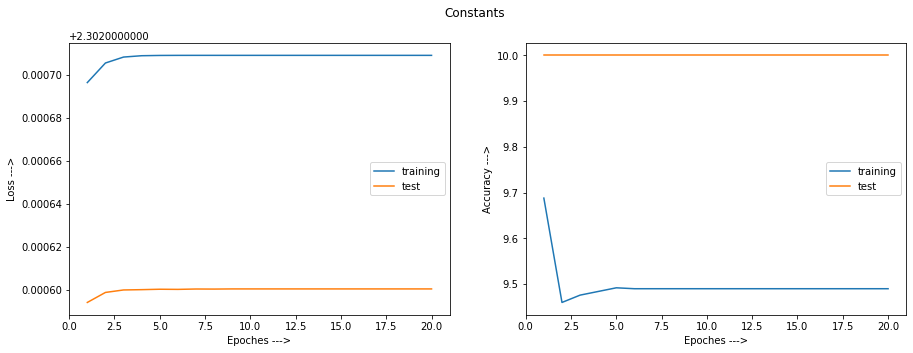

In [16]:
show_rlt(rlt_const, 'Constants')

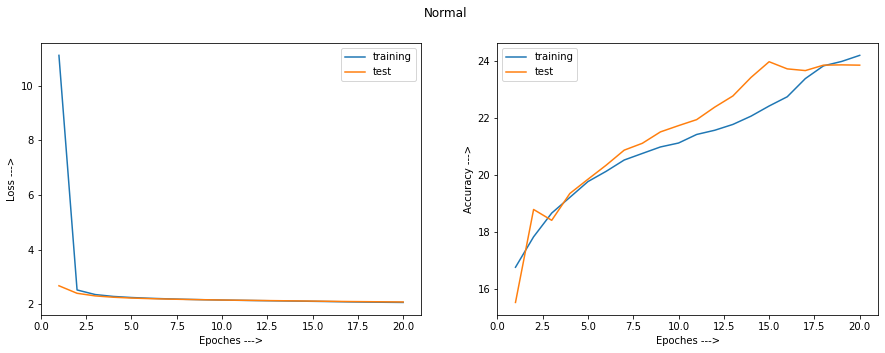

In [17]:
show_rlt(rlt_normal, 'Normal')

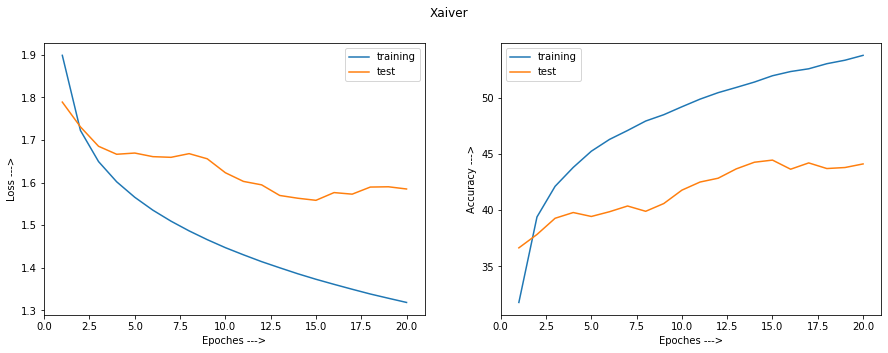

In [18]:
show_rlt(rlt_xaiver, 'Xaiver')

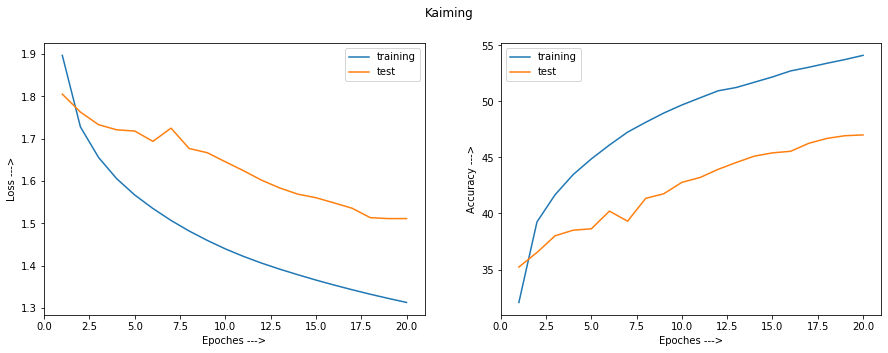

In [19]:
show_rlt(rlt_kaiming, 'Kaiming')

## 2. 위 4개의 초기화 방법를 비교하고 성능에 대해서 분석하시오

정답) 

초기화시에 가장 차이가 있는 것 -> initialization을 무엇으로 할 것인가 (이때 활성화 함수에 따라서 달라진다. 수업시간에 배운 대표적인 함수는 2개인데 ReLu와 sigmoid이다. 보통의 경우 Relu 함수에서는 He가 잘 적용이 된다. 그렇다고 절대적인 것은 아니다. 참고) sigmoid에서는 xavier

'Constants' 경우에는 가장 좋지 않은 성능을 보인다고 생각한다. Loss를 다이나믹하게 잘 줄이는가? 아니다. 그렇다면 Accruacy는 높나? 아니다.  train 데이터에서는 제대로 학습도 되지 않아 Accruacy가 높지 않다.

'Normal' 경우 Loss 값도 적절하게 잘 줄이고, train data와 test data의 간극도 짧아 어느 하나 overfitting 되지 않고 이상적으로 보인다. 하지만 Accruacy가 비교적 낮다.

'Xaiver'의 경우 Loss 값을 적절하게 잘 줄인다. Accruacy는 비교적 훌륭하나 (50%정도라서 객관적이라고는 볼 수 없지만 비교적 다른 초기화 기법에 비해 훌륭하다는 뜻) train data와 test data의 간극이 점점 벌어진다. 이것은 overfitting 되었다는 여지가 있는 것으로 성능을 좋다고 하기에는 무리가 있다. (심지어 train data의 Accruacy가 50% 보다 훨씬 좋더라도 test data와의 간극이 그만큼 크다면 overfitting 된 것으로, Accruacy가 조금 작더라도 간극이 적은 것이 더 좋다.)

'Kaiming' 즉 He initialization을 했을 때 가장 성능이 좋다. Loss 값을 줄이는 것은 Xaiver와 비슷해 보인다. 하지만 Accruacy가 높고 train data와 test data의 간극도 짧아 가장 좋은 성능을 가진다고 볼 수 있다.
